# HHCART(D) on the Hamarat et al. 2013 Model

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from ema_workbench import load_results
from ema_workbench.analysis import RuleInductionType
from ema_workbench.analysis.feature_scoring import get_ex_feature_scores

from HHCART_SD import HHCartD, load_model
from plot_outcomes_lineplot_gaussian import plot_fraction_renewables
from clean_hamarat import clean_results
from run_hhcart_over_top_features import run_hhcart_over_top_features
from src.config.paths import HAMARAT_DATA_DIR

## Load and Clean the Data

In [2]:
# Load results
experiments, outcomes = load_results(HAMARAT_DATA_DIR / "10000_lhs.tar.gz")

# Clean data → get X and y
X, y_continuous = clean_results(experiments, outcomes)

 ## Plot the Data

Figure saved: renewables_over_time_0_6_threshold.pdf


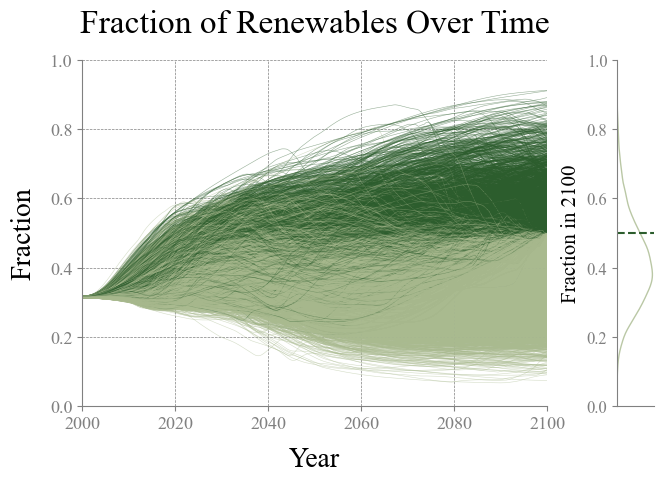


At threshold the threshold of 50.0% renewables by 2100:
22.8% of cases exceed threshold (2281 of 10000), 77.2% of cases below threshold (7719 of 10000)


In [3]:
plot_fraction_renewables(outcomes, threshold=0.5, save_path="renewables_over_time_0_6_threshold.pdf")

## Set Binary Threshold for y

In [4]:
threshold_value = 0.5  # for example
y = (y_continuous > threshold_value).astype(int)

In [5]:
# Convert categorical variables to dummy variables
categorical_cols = [col for col in X.columns if str(X[col].dtype) == 'category']
X_dummy = pd.get_dummies(X, columns=categorical_cols, drop_first=True, dtype=float)

print(f"\nChanged categorical variables to dummy variables making the experiments Dataframe gain {X_dummy.shape[1]-X.shape[1]} columns.")


Changed categorical variables to dummy variables making the experiments Dataframe gain 22 columns.


In [6]:
# # Drop SWITCH columns, as they are not needed for the analysis
# switch_cols = [col for col in X_dummy.columns if col.startswith("SWITCH")]
# X_encoded = X_dummy.drop(columns=switch_cols)

## Applying HHCART(D)

In [7]:
# Set tree parameters
max_depth = 8
min_purity = 0.95
mass_min = 0.05

# Instantiate HHCART, build and save tree
hh = HHCartD(X_dummy, y, min_purity=min_purity, mass_min=mass_min, max_depth=max_depth)
hh.build_tree(f"hamarat_depth_{max_depth}_pur_{str(min_purity).replace('.', '_')}_mass_{str(mass_min).replace('.', '_')}")

[INFO] Building HHCartD oblique decision tree...
[INFO] Max number of nodes allowed by minimum mass constraint: 31 (used as progress bar target; actual number of splits unknown in advance).


Building tree nodes: 65it [56:02, 51.73s/it]                          


[INFO] Pruning the full tree and evaluating metrics at each depth level; storing pruned trees and metrics...
[SAVED] HHCartD model saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hamarat_depth_8_pur_0_95_mass_0_05\model
[OK] Tree of depth 8 built and saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hamarat_depth_8_pur_0_95_mass_0_05


In [8]:
hh = load_model("hamarat_depth_8_pur_0_95_mass_0_05")
hh.select(depth=3)
hh.inspect()

[LOADED] HHCartD model loaded from: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hamarat_depth_8_pur_0_95_mass_0_05\model
[OK] Selected tree at depth 3.

[INSPECT] Inspecting tree at selected depth 3...

[Node id=0, depth=0, impurity=0.3350] (split: +0.00*x1 +0.00*x2 -0.00*x3 +0.00*x7 +0.00*x8 +0.00*x27 -0.00*x30 +0.00*x32 +1.00*x33 + -1.27 >= 0)
├── [Node id=1, depth=1, impurity=0.4434] (split: +0.00*x0 -0.00*x1 -0.00*x2 -0.00*x3 +0.00*x4 -0.00*x5 +0.00*x6 -0.00*x7 -0.00*x8 +0.00*x9 -0.00*x10 +0.00*x11 +0.00*x12 -0.00*x26 -0.00*x27 +1.00*x28 +0.00*x29 -0.00*x30 +0.00*x31 -0.00*x32 +0.00*x34 -0.00*x35 -0.00*x37 +0.00*x38 +0.00*x39 +0.00*x40 +0.00*x41 -0.00*x43 -0.00*x44 +0.00*x46 -0.00*x47 +0.00*x48 -0.00*x49 -0.00*x50 -0.00*x51 +0.00*x52 +0.00*x53 -0.00*x55 +0.00*x56 -0.00*x58 -0.00*x59 -0.00*x61 +0.00*x62 -0.00*x64 -0.00*x65 + +2.96 >= 0)
├── ├── [Node id=2, depth=2, impurity=0.3562] (split: -0.00*x1 +0.00*x5 +

In [9]:
hh.plot_tree_structure(depth=6, save=True)

[SAVE] Graphviz tree saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hamarat_depth_8_pur_0_95_mass_0_05/tree_structure_d6.pdf


[SAVED] Figure saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hamarat_depth_8_pur_0_95_mass_0_05\metrics_vs_depth.pdf


(<Figure size 600x450 with 1 Axes>,
 <Axes: title={'center': 'Performance Metrics vs. Tree Depth'}, xlabel='Tree Depth', ylabel='Score'>)

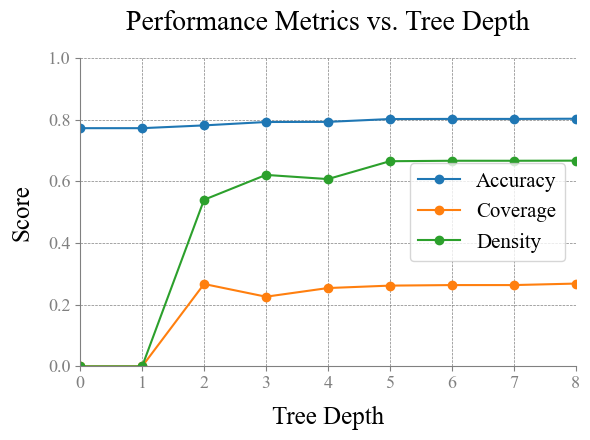

In [10]:
hh.plot_metrics_vs_structure(save=True)

[SAVED] Figure saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hamarat_depth_8_pur_0_95_mass_0_05\metrics_vs_class1_leaf_count.pdf


(<Figure size 600x450 with 1 Axes>,
 <Axes: title={'center': 'Performance Metrics vs. Class 1 Leaf Count'}, xlabel='Class 1 Leaf Count', ylabel='Score'>)

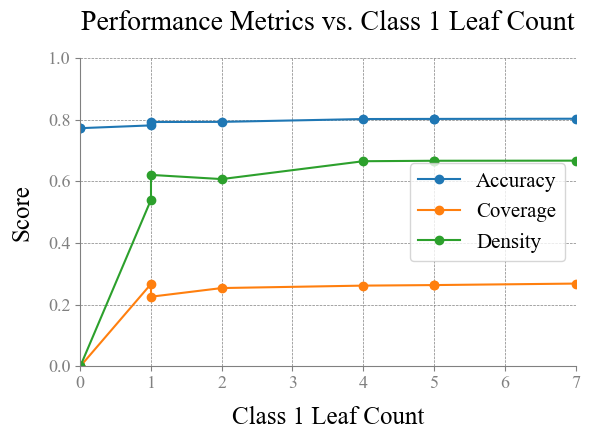

In [11]:
hh.plot_metrics_vs_structure(save=True, x_axis="class1_leaf_count")

[SAVED] Figure saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hamarat_depth_8_pur_0_95_mass_0_05\coverage_density_path_depth.pdf


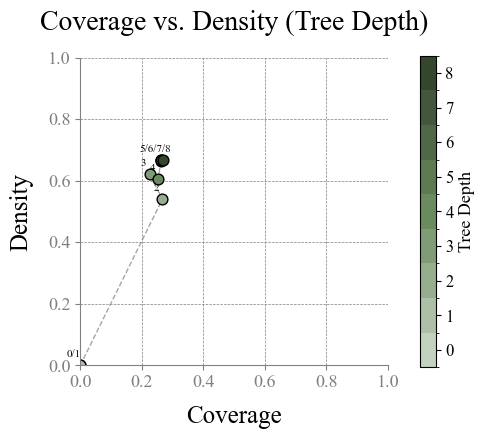

In [12]:
hh.plot_tradeoff_path(save=True)

[SAVED] Figure saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hamarat_depth_8_pur_0_95_mass_0_05\coverage_density_path_class1_leaf_count.pdf


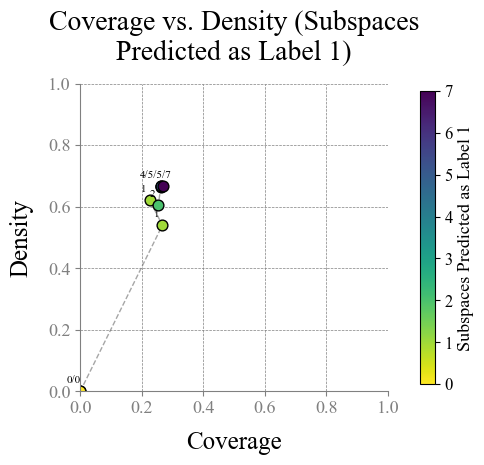

In [13]:
hh.plot_tradeoff_path(save=True, color_by="class1_leaf_count")

[SAVED] Figure saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hamarat_depth_8_pur_0_95_mass_0_05\node_size_distribution.pdf


(<Figure size 550x400 with 1 Axes>,
 <Axes: title={'center': 'Node Size Distribution by Depth'}, xlabel='Tree Depth', ylabel='Samples per Node'>)

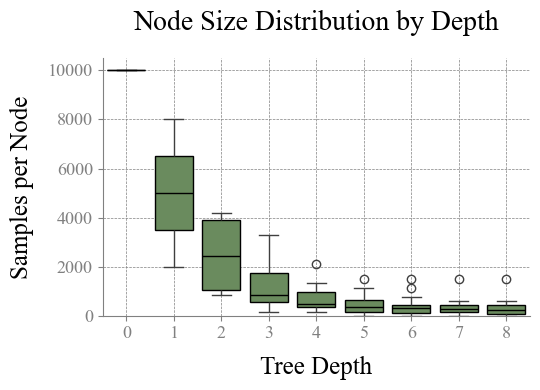

In [14]:
hh.plot_node_size_distribution(save=True)

## Applying Extra Trees Feature Scoring to Determine Features of Interest

In [7]:
feature_scores_class, model_class = get_ex_feature_scores(
    x=X_dummy,
    y=y,
    mode=RuleInductionType.CLASSIFICATION,
    nr_trees=250,
    max_features=None,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=True,
    oob_score=True,
    random_state=42
)

### Print the Top Features

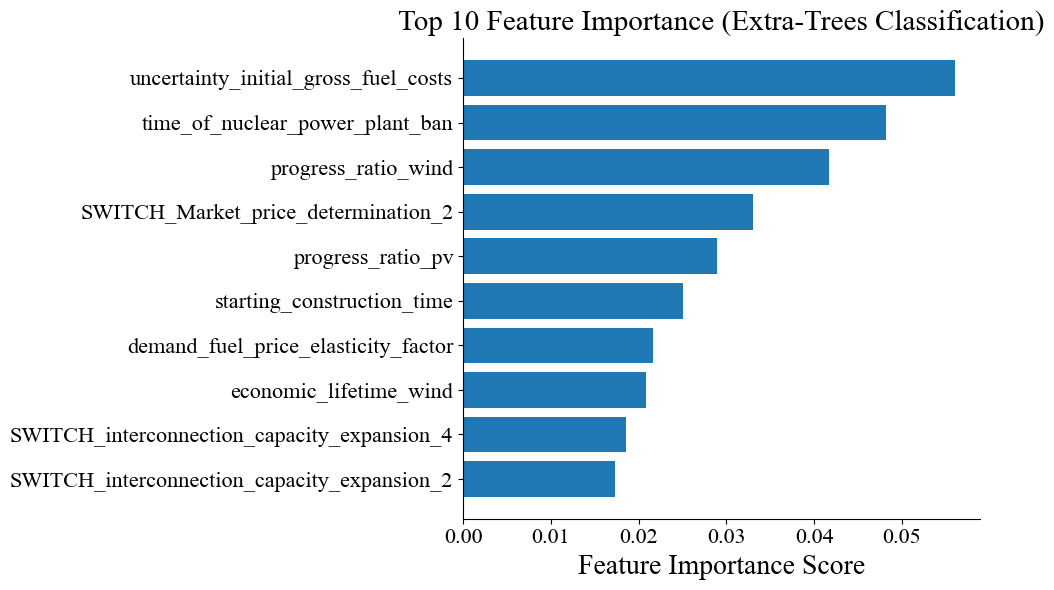

In [8]:
top_n = 10
top_features_class = feature_scores_class.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_features_class.index, top_features_class.iloc[:, 0])  # assuming first column is the score
plt.xlabel('Feature Importance Score')
plt.title('Top 10 Feature Importance (Extra-Trees Classification)')
plt.gca().invert_yaxis()  # highest importance on top
plt.tight_layout()
plt.show()

In [9]:
# Convert to list of top features
top_features_ordered = feature_scores_class.index.tolist()

## Loop Over Top-N Features and Build HHCART(D)


[RUN] Building HHCartD with top 2 features: ['uncertainty_initial_gross_fuel_costs', 'time_of_nuclear_power_plant_ban']
[INFO] Model title: hhcart_top2f_dep_8_mass_0_05_pur_0_95_unc_tim
[INFO] Building HHCartD oblique decision tree...
[INFO] Max number of nodes allowed by maximum depth constraint: 511 (used as progress bar target; actual number of splits unknown in advance).


Building tree nodes:  16%|█▌        | 83/511 [01:55<09:56,  1.39s/it] 


[INFO] Pruning the full tree and evaluating metrics at each depth level; storing pruned trees and metrics...
[SAVED] HHCartD model saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top2f_dep_8_mass_0_05_pur_0_95_unc_tim\model
[OK] Tree of depth 8 built and saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top2f_dep_8_mass_0_05_pur_0_95_unc_tim
[OK] Selected tree at depth 0.
[SAVE] Graphviz tree saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top2f_dep_8_mass_0_05_pur_0_95_unc_tim/tree_structure_d0.pdf
[OK] Selected tree at depth 1.
[SAVE] Graphviz tree saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top2f_dep_8_mass_0_05_pur_0_95_unc_tim/tree_s

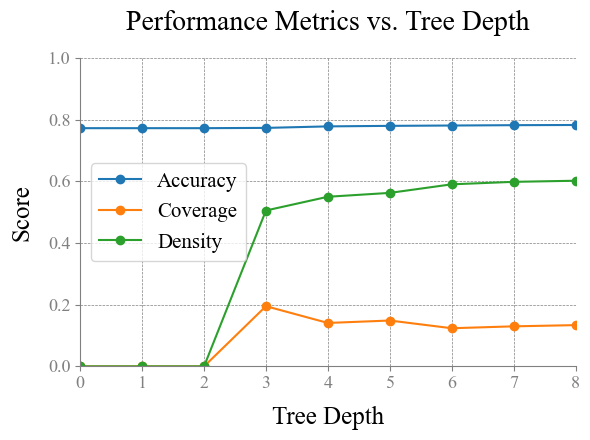

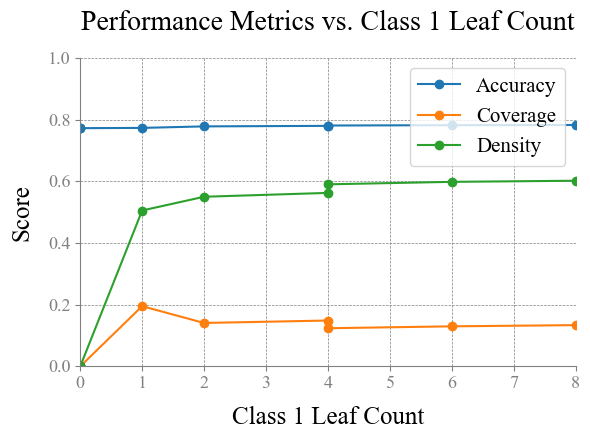

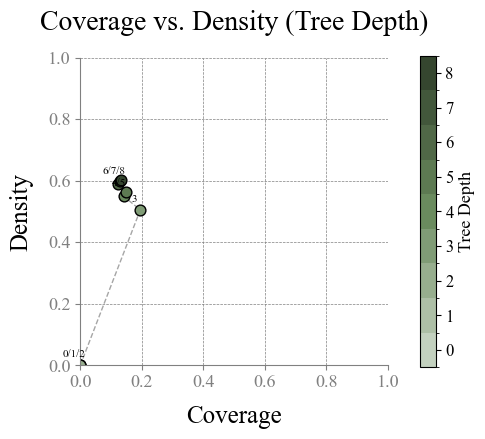

[SAVED] Figure saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top2f_dep_8_mass_0_05_pur_0_95_unc_tim\coverage_density_path_class1_leaf_count.pdf


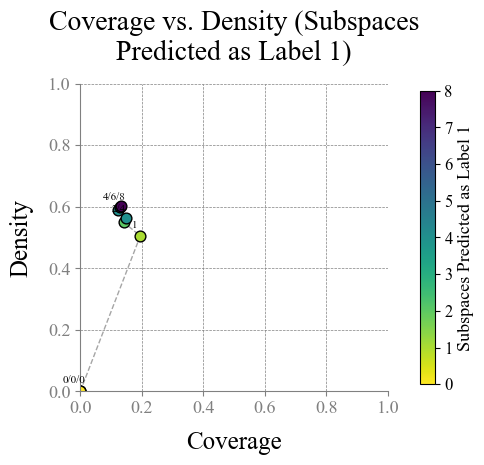

[SAVED] Figure saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top2f_dep_8_mass_0_05_pur_0_95_unc_tim\node_size_distribution.pdf
[DONE] Finished run with top 2 features.

[RUN] Building HHCartD with top 3 features: ['uncertainty_initial_gross_fuel_costs', 'time_of_nuclear_power_plant_ban', 'progress_ratio_wind']
[INFO] Model title: hhcart_top3f_dep_8_mass_0_05_pur_0_95_unc_tim_pro
[INFO] Building HHCartD oblique decision tree...
[INFO] Max number of nodes allowed by maximum depth constraint: 511 (used as progress bar target; actual number of splits unknown in advance).


Building tree nodes:  15%|█▌        | 77/511 [03:18<18:37,  2.58s/it] 


[INFO] Pruning the full tree and evaluating metrics at each depth level; storing pruned trees and metrics...
[SAVED] HHCartD model saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top3f_dep_8_mass_0_05_pur_0_95_unc_tim_pro\model
[OK] Tree of depth 8 built and saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top3f_dep_8_mass_0_05_pur_0_95_unc_tim_pro
[OK] Selected tree at depth 0.
[SAVE] Graphviz tree saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top3f_dep_8_mass_0_05_pur_0_95_unc_tim_pro/tree_structure_d0.pdf
[OK] Selected tree at depth 1.
[SAVE] Graphviz tree saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top3f_dep_8_mass_0_05_pur_0_95_un

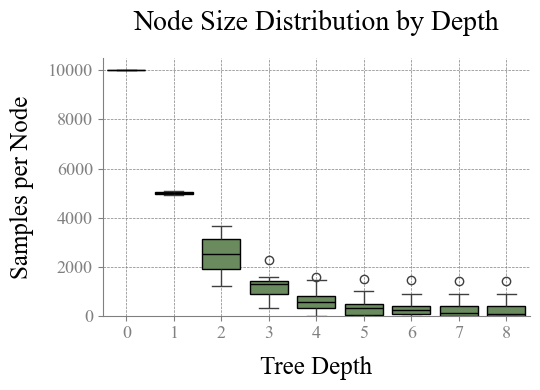

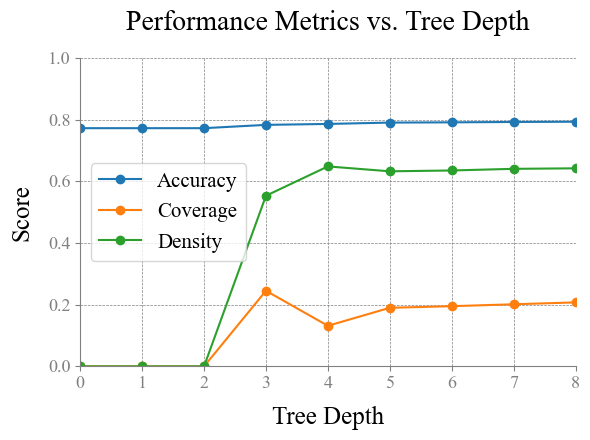

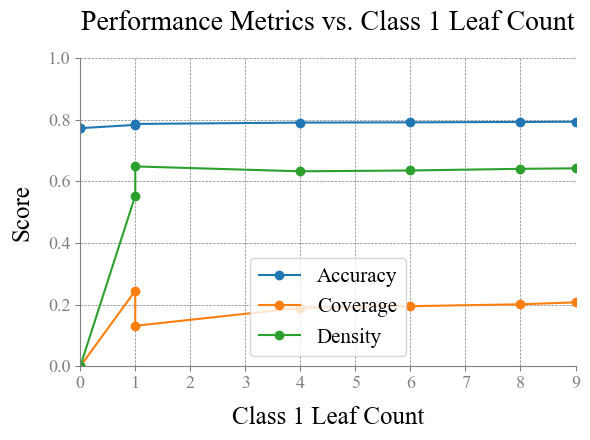

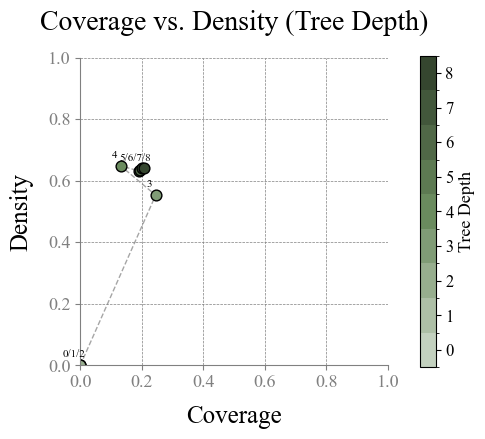

[SAVED] Figure saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top3f_dep_8_mass_0_05_pur_0_95_unc_tim_pro\coverage_density_path_class1_leaf_count.pdf


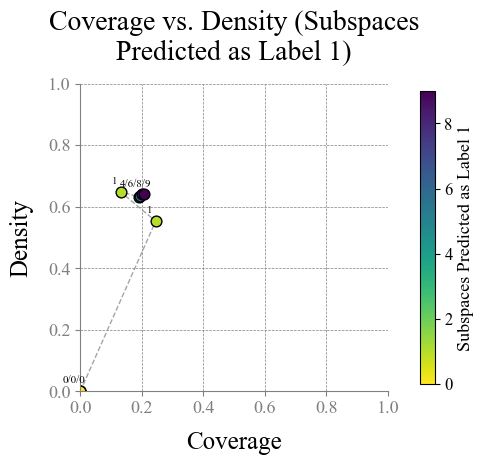

[SAVED] Figure saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top3f_dep_8_mass_0_05_pur_0_95_unc_tim_pro\node_size_distribution.pdf
[DONE] Finished run with top 3 features.

[RUN] Building HHCartD with top 4 features: ['uncertainty_initial_gross_fuel_costs', 'time_of_nuclear_power_plant_ban', 'progress_ratio_wind', 'SWITCH_Market_price_determination_2']
[INFO] Model title: hhcart_top4f_dep_8_mass_0_05_pur_0_95_unc_tim_pro_SWI
[INFO] Building HHCartD oblique decision tree...
[INFO] Max number of nodes allowed by maximum depth constraint: 511 (used as progress bar target; actual number of splits unknown in advance).


Building tree nodes:  12%|█▏        | 63/511 [04:43<33:38,  4.51s/it]  


[INFO] Pruning the full tree and evaluating metrics at each depth level; storing pruned trees and metrics...
[SAVED] HHCartD model saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top4f_dep_8_mass_0_05_pur_0_95_unc_tim_pro_SWI\model
[OK] Tree of depth 8 built and saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top4f_dep_8_mass_0_05_pur_0_95_unc_tim_pro_SWI
[OK] Selected tree at depth 0.
[SAVE] Graphviz tree saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top4f_dep_8_mass_0_05_pur_0_95_unc_tim_pro_SWI/tree_structure_d0.pdf
[OK] Selected tree at depth 1.
[SAVE] Graphviz tree saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top4f_dep_8_mass_0_05

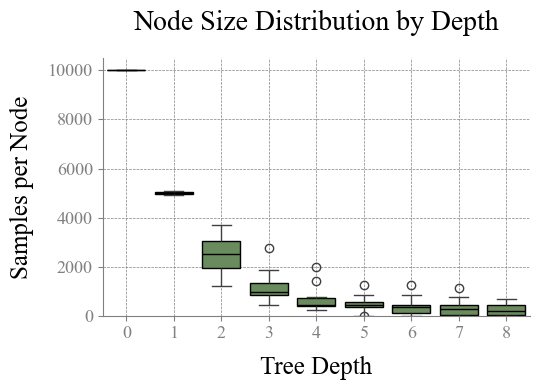

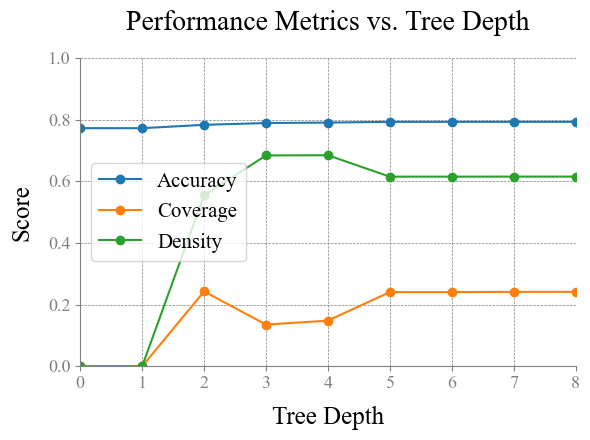

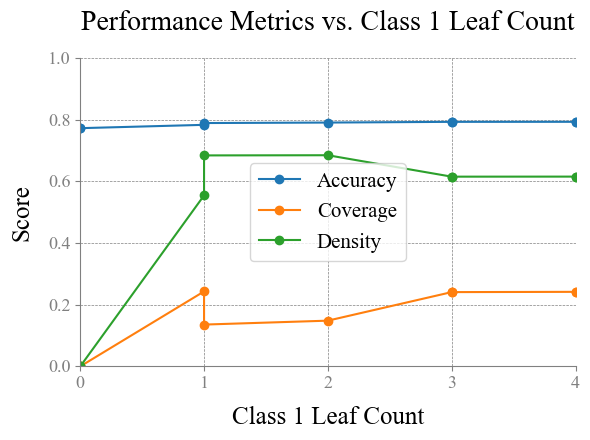

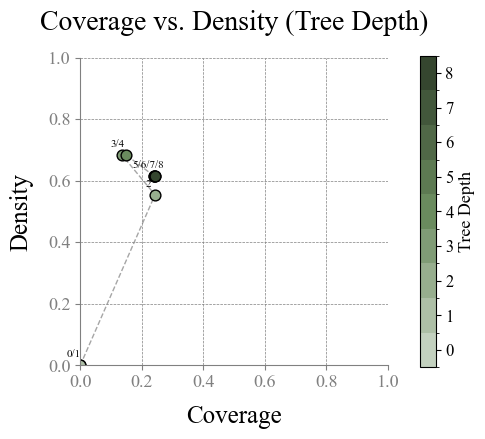

[SAVED] Figure saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top4f_dep_8_mass_0_05_pur_0_95_unc_tim_pro_SWI\coverage_density_path_class1_leaf_count.pdf


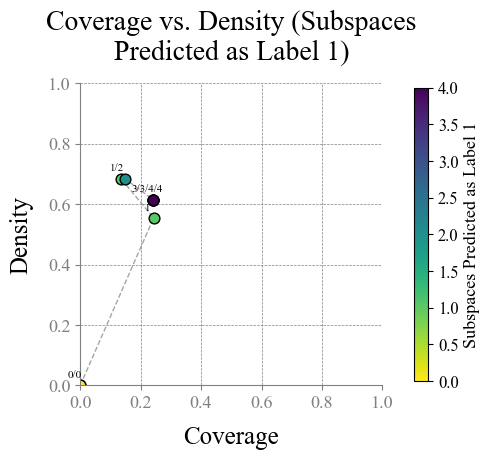

[SAVED] Figure saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top4f_dep_8_mass_0_05_pur_0_95_unc_tim_pro_SWI\node_size_distribution.pdf
[DONE] Finished run with top 4 features.

[RUN] Building HHCartD with top 5 features: ['uncertainty_initial_gross_fuel_costs', 'time_of_nuclear_power_plant_ban', 'progress_ratio_wind', 'SWITCH_Market_price_determination_2', 'progress_ratio_pv']
[INFO] Model title: hhcart_top5f_dep_8_mass_0_05_pur_0_95_unc_tim_pro_SWI_pro
[INFO] Building HHCartD oblique decision tree...
[INFO] Max number of nodes allowed by maximum depth constraint: 511 (used as progress bar target; actual number of splits unknown in advance).


Building tree nodes:  13%|█▎        | 67/511 [05:08<34:03,  4.60s/it]  


[INFO] Pruning the full tree and evaluating metrics at each depth level; storing pruned trees and metrics...
[SAVED] HHCartD model saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top5f_dep_8_mass_0_05_pur_0_95_unc_tim_pro_SWI_pro\model
[OK] Tree of depth 8 built and saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top5f_dep_8_mass_0_05_pur_0_95_unc_tim_pro_SWI_pro
[OK] Selected tree at depth 0.
[SAVE] Graphviz tree saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top5f_dep_8_mass_0_05_pur_0_95_unc_tim_pro_SWI_pro/tree_structure_d0.pdf
[OK] Selected tree at depth 1.
[SAVE] Graphviz tree saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top5f_dep

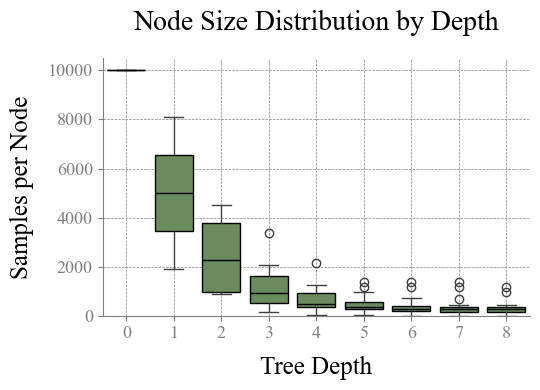

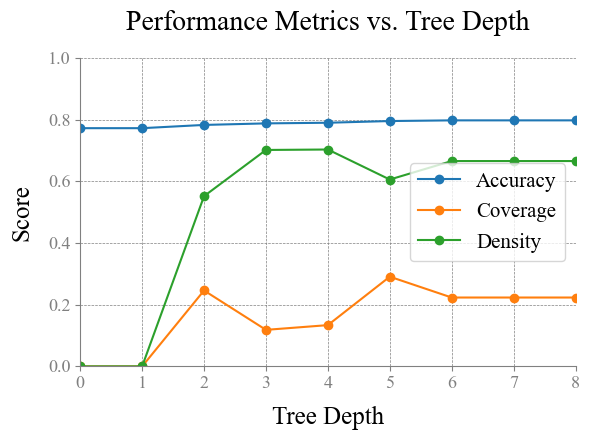

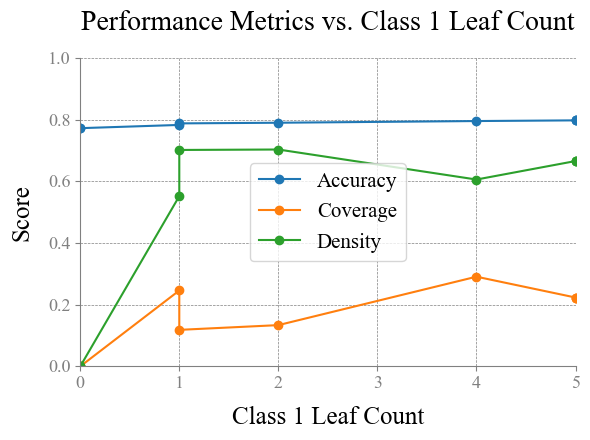

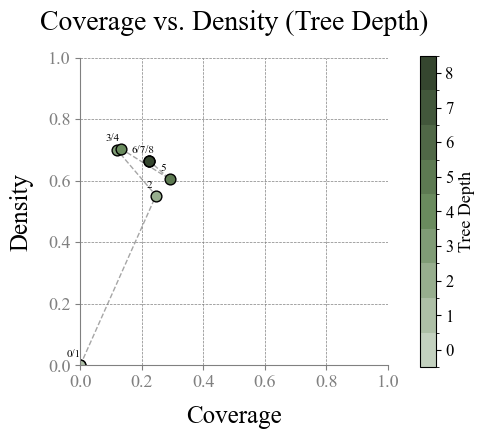

[SAVED] Figure saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top5f_dep_8_mass_0_05_pur_0_95_unc_tim_pro_SWI_pro\coverage_density_path_class1_leaf_count.pdf


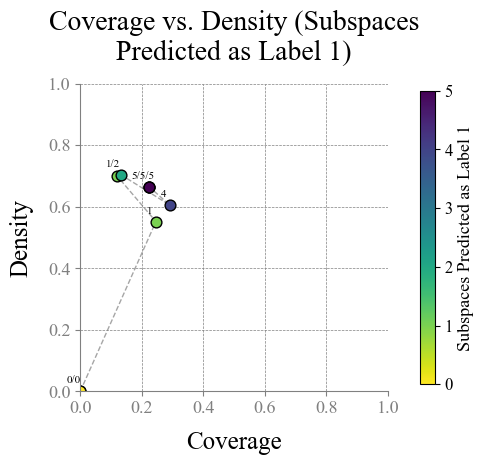

[SAVED] Figure saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top5f_dep_8_mass_0_05_pur_0_95_unc_tim_pro_SWI_pro\node_size_distribution.pdf
[DONE] Finished run with top 5 features.

[RUN] Building HHCartD with top 6 features: ['uncertainty_initial_gross_fuel_costs', 'time_of_nuclear_power_plant_ban', 'progress_ratio_wind', 'SWITCH_Market_price_determination_2', 'progress_ratio_pv', 'starting_construction_time']
[INFO] Model title: hhcart_top6f_dep_8_mass_0_05_pur_0_95_unc_tim_pro_SWI_pro_sta
[INFO] Building HHCartD oblique decision tree...
[INFO] Max number of nodes allowed by maximum depth constraint: 511 (used as progress bar target; actual number of splits unknown in advance).


Building tree nodes:  14%|█▍        | 71/511 [06:41<41:26,  5.65s/it]  


[INFO] Pruning the full tree and evaluating metrics at each depth level; storing pruned trees and metrics...
[SAVED] HHCartD model saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top6f_dep_8_mass_0_05_pur_0_95_unc_tim_pro_SWI_pro_sta\model
[OK] Tree of depth 8 built and saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top6f_dep_8_mass_0_05_pur_0_95_unc_tim_pro_SWI_pro_sta
[OK] Selected tree at depth 0.
[SAVE] Graphviz tree saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top6f_dep_8_mass_0_05_pur_0_95_unc_tim_pro_SWI_pro_sta/tree_structure_d0.pdf
[OK] Selected tree at depth 1.
[SAVE] Graphviz tree saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhca

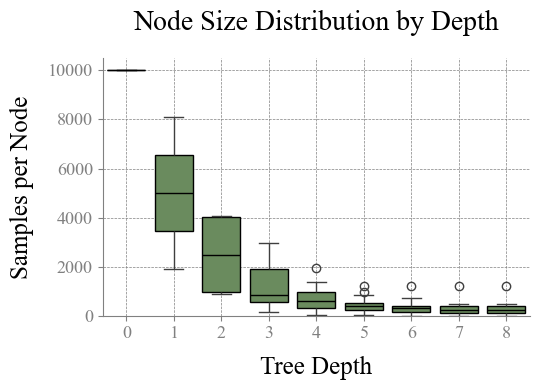

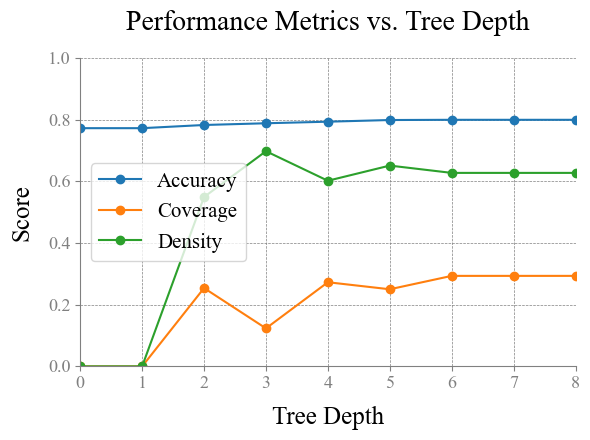

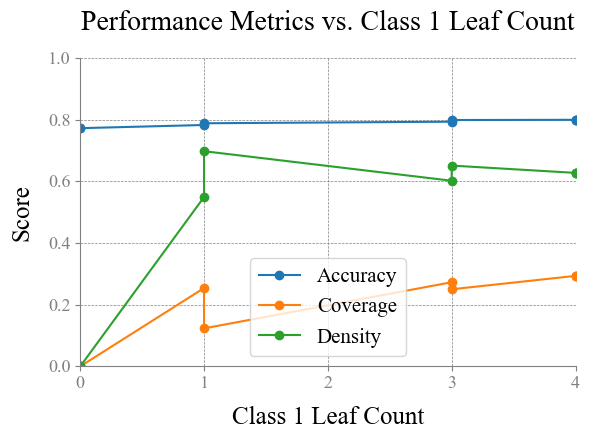

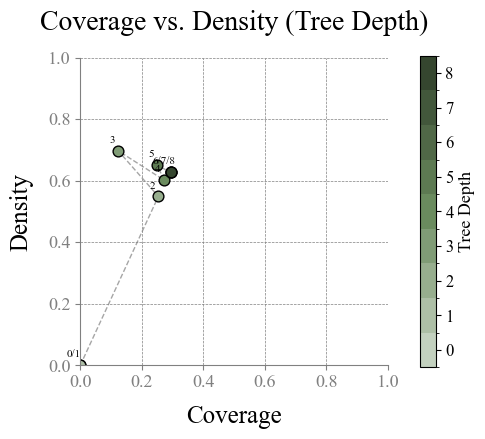

[SAVED] Figure saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top6f_dep_8_mass_0_05_pur_0_95_unc_tim_pro_SWI_pro_sta\coverage_density_path_class1_leaf_count.pdf


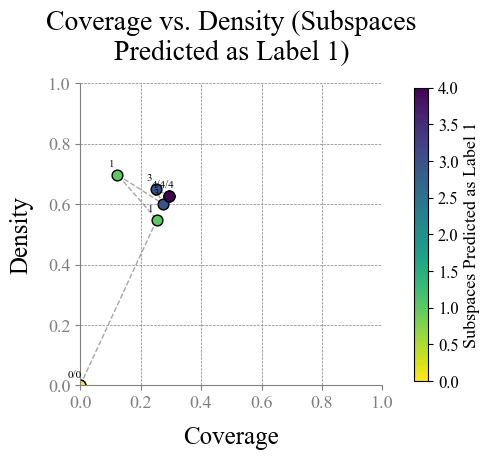

[SAVED] Figure saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top6f_dep_8_mass_0_05_pur_0_95_unc_tim_pro_SWI_pro_sta\node_size_distribution.pdf
[DONE] Finished run with top 6 features.

[RUN] Building HHCartD with top 7 features: ['uncertainty_initial_gross_fuel_costs', 'time_of_nuclear_power_plant_ban', 'progress_ratio_wind', 'SWITCH_Market_price_determination_2', 'progress_ratio_pv', 'starting_construction_time', 'demand_fuel_price_elasticity_factor']
[INFO] Model title: hhcart_top7f_dep_8_mass_0_05_pur_0_95_unc_tim_pro_SWI_pro_sta_dem
[INFO] Building HHCartD oblique decision tree...
[INFO] Max number of nodes allowed by maximum depth constraint: 511 (used as progress bar target; actual number of splits unknown in advance).


Building tree nodes:  12%|█▏        | 61/511 [21:15<2:36:46, 20.90s/it] 


[INFO] Pruning the full tree and evaluating metrics at each depth level; storing pruned trees and metrics...
[SAVED] HHCartD model saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top7f_dep_8_mass_0_05_pur_0_95_unc_tim_pro_SWI_pro_sta_dem\model
[OK] Tree of depth 8 built and saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top7f_dep_8_mass_0_05_pur_0_95_unc_tim_pro_SWI_pro_sta_dem
[OK] Selected tree at depth 0.
[SAVE] Graphviz tree saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top7f_dep_8_mass_0_05_pur_0_95_unc_tim_pro_SWI_pro_sta_dem/tree_structure_d0.pdf
[OK] Selected tree at depth 1.
[SAVE] Graphviz tree saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_mod

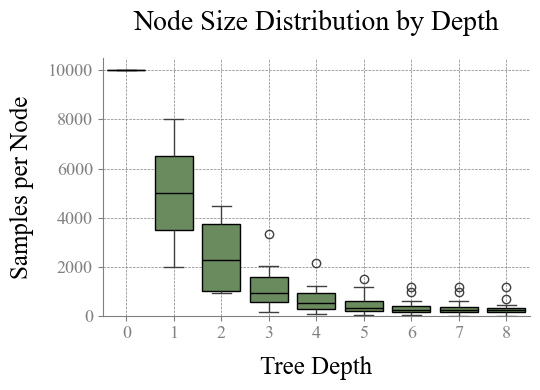

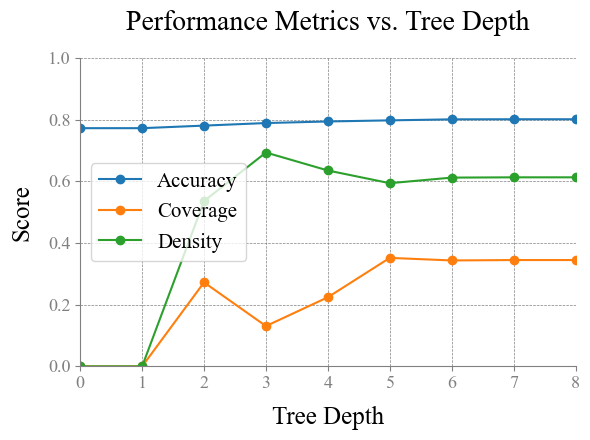

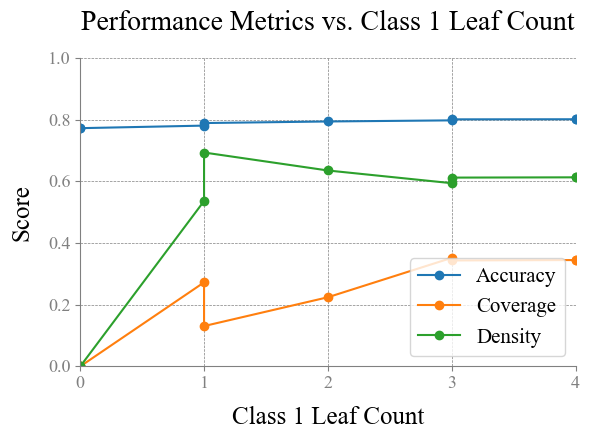

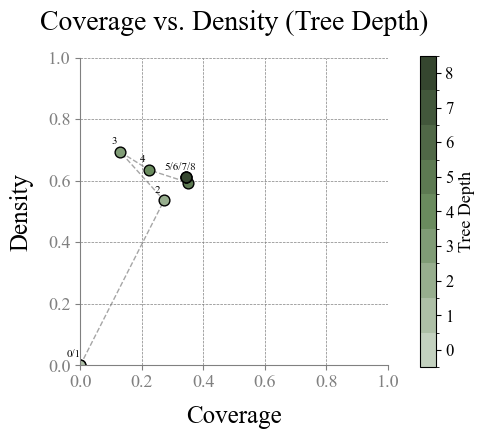

[SAVED] Figure saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top7f_dep_8_mass_0_05_pur_0_95_unc_tim_pro_SWI_pro_sta_dem\coverage_density_path_class1_leaf_count.pdf


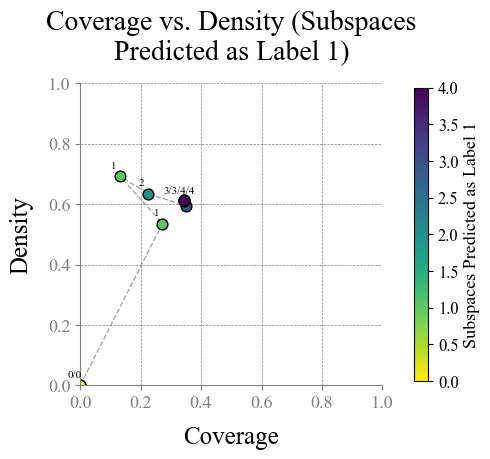

[SAVED] Figure saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top7f_dep_8_mass_0_05_pur_0_95_unc_tim_pro_SWI_pro_sta_dem\node_size_distribution.pdf
[DONE] Finished run with top 7 features.

[RUN] Building HHCartD with top 8 features: ['uncertainty_initial_gross_fuel_costs', 'time_of_nuclear_power_plant_ban', 'progress_ratio_wind', 'SWITCH_Market_price_determination_2', 'progress_ratio_pv', 'starting_construction_time', 'demand_fuel_price_elasticity_factor', 'economic_lifetime_wind']
[INFO] Model title: hhcart_top8f_dep_8_mass_0_05_pur_0_95_unc_tim_pro_SWI_pro_sta_dem_eco
[INFO] Building HHCartD oblique decision tree...
[INFO] Max number of nodes allowed by maximum depth constraint: 511 (used as progress bar target; actual number of splits unknown in advance).


Building tree nodes:   0%|          | 0/511 [00:00<?, ?it/s]

In [ ]:
# HHCART config
max_depth = 8
min_purity = 0.95
mass_min = 0.05

run_hhcart_over_top_features(
    X_full=X_dummy,
    y=y,
    feature_scores=feature_scores_class,
    top_n_range=(2,9),  # will run for 2 to 9 features
    max_depth=8,
    mass_min=0.05,
    min_purity=0.95,
    debug=False
)

# How many top features to test
top_n_range = list(range(2, 9))  # 2 to 8

# Loop
for n_feats in top_n_range:
    # Select top N features
    selected_features = top_features_ordered[:n_feats]

    # Subset X
    X_selected = X_dummy[selected_features].copy()

    # Build HHCART
    print(f"\n[RUN] Building HHCART(D) with top {n_feats} features: {selected_features}")

    hh = HHCartD(
        X_selected,
        y,
        min_purity=min_purity,
        mass_min=mass_min,
        max_depth=max_depth
    )

    # Prepare model name with features included in name
    feature_name_str = "_".join([feat.replace(" ", "").replace("(", "").replace(")", "") for feat in selected_features])
    model_title = f"hhcart_top{n_feats}_features_{feature_name_str}"

    # Build and save model
    hh.build_tree(model_title)

    # Loop over depths and generate plots
    for depth in hh.available_depths():
        hh.plot_tree_structure(depth=depth, save=True)

    hh.plot_metrics_vs_structure(save=True)
    hh.plot_metrics_vs_structure(save=True, x_axis="class1_leaf_count")
    hh.plot_tradeoff_path(save=True)
    hh.plot_tradeoff_path(save=True, color_by="class1_leaf_count")
    hh.plot_node_size_distribution(save=True)

    print(f"[DONE] Finished run with top {n_feats} features.\n{'=' * 80}")